CODE BLOCK: 1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

CODE BLOCK: 2

In [2]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


CODE BLOCK: 3

In [4]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(32), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-30., 30.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

CODE BLOCK: 4

In [5]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=True, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 13.6MB/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 521kB/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.69MB/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



CODE BLOCK: 5

In [6]:
batch_size = 2

kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

In [14]:
image_iter = iter(train_loader)

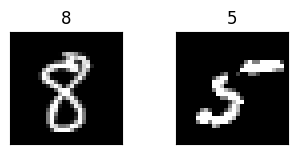

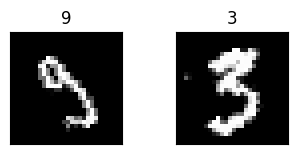

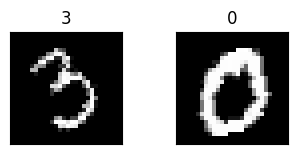

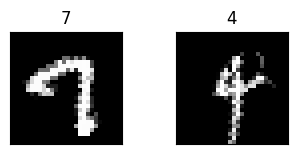

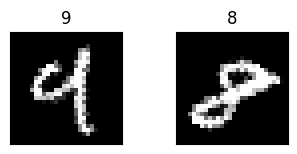

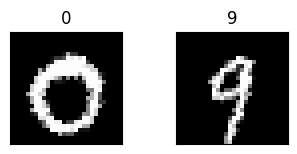

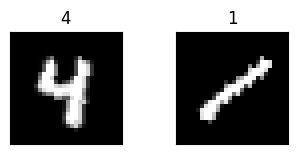

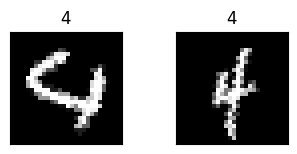

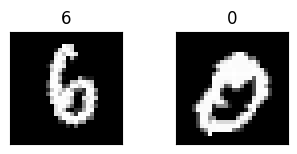

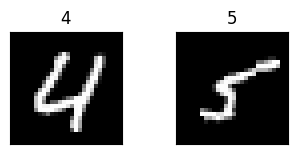

In [20]:
import matplotlib.pyplot as plt

fig = plt.figure()
for ele in range(10):
  batch_data, batch_label = next(image_iter)
  for i in range(2):
    plt.subplot(3,4,i+1)
    plt.tight_layout()
    plt.imshow(batch_data[i].squeeze(0), cmap='gray')
    plt.title(batch_label[i].item())
    plt.xticks([])
    plt.yticks([])
  plt.show()

CODE BLOCK: 7

In [8]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3)
        self.conv4 = nn.Conv2d(16, 32, kernel_size=3)
        self.fc1 = nn.Linear(512, 35)
        self.fc3 = nn.Linear(35, 10)

        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(32)

        self.flatten = nn.Flatten()

    def forward(self, x):
        x = F.relu(self.conv1(x), 2)
        x = F.relu(self.bn1(F.max_pool2d(self.conv2(x), 2)))
        # x = self.dropout1(x)
        x = F.relu(self.conv3(x), 2)
        x = F.relu(self.bn2(F.max_pool2d(self.conv4(x), 2)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        # x = self.dropout2(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

CODE BLOCK: 8

In [9]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [10]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred,  target.squeeze())
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)

In [34]:
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              40
            Conv2d-2            [-1, 8, 24, 24]             296
       BatchNorm2d-3            [-1, 8, 12, 12]              16
            Conv2d-4           [-1, 16, 10, 10]           1,168
            Conv2d-5             [-1, 32, 8, 8]           4,640
       BatchNorm2d-6             [-1, 32, 4, 4]              64
           Flatten-7                  [-1, 512]               0
            Linear-8                   [-1, 35]          17,955
            Linear-9                   [-1, 10]             360
Total params: 24,539
Trainable params: 24,539
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.10
Params size (MB): 0.09
Estimated Total Size (MB): 0.20
---------------------------------------------

In [35]:
optimizer = optim.SGD(model.parameters(), lr=0.00075, momentum=0.9) # Initialize the optimizer to SGD with learning rate 0.01 and momentum 0.9.
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.0005, verbose=True)

# New Line
criterion = nn.CrossEntropyLoss()
num_epochs = 3

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, train_loader, criterion)
  scheduler.step()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1


Train: Loss=0.0005 Batch_id=29999 Accuracy=96.17: 100%|██████████| 30000/30000 [04:21<00:00, 114.71it/s]


Test set: Average loss: 0.0333, Accuracy: 58701/60000 (97.83%)

Epoch 2


Train: Loss=0.0003 Batch_id=29999 Accuracy=98.53: 100%|██████████| 30000/30000 [04:20<00:00, 115.33it/s]


Test set: Average loss: 0.0270, Accuracy: 58943/60000 (98.24%)

Epoch 3


Train: Loss=0.0005 Batch_id=29999 Accuracy=98.89: 100%|██████████| 30000/30000 [04:18<00:00, 115.94it/s]


Test set: Average loss: 0.0275, Accuracy: 58966/60000 (98.28%)



In [14]:
batch_data, _ = next(iter(test_loader))

In [15]:
batch_data.shape, batch_data[0].shape

(torch.Size([2, 1, 28, 28]), torch.Size([1, 28, 28]))

In [16]:
output = model(batch_data.to(device))
output

tensor([[-1.6006e+01, -1.4102e+01, -1.6900e+01, -9.5467e+00, -1.8857e+01,
         -8.1417e-05, -1.4196e+01, -1.5647e+01, -1.1762e+01, -1.5034e+01],
        [-3.0994e-06, -2.0634e+01, -1.4263e+01, -2.1104e+01, -1.7742e+01,
         -1.6124e+01, -1.3946e+01, -2.2369e+01, -1.3542e+01, -1.5779e+01]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)

In [26]:
output = model(batch_data[0].unsqueeze(0).to(device))
output.shape

torch.Size([1, 10])

torch.Size([1, 1, 28, 28])

In [29]:
train_acc

[96.245]

CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

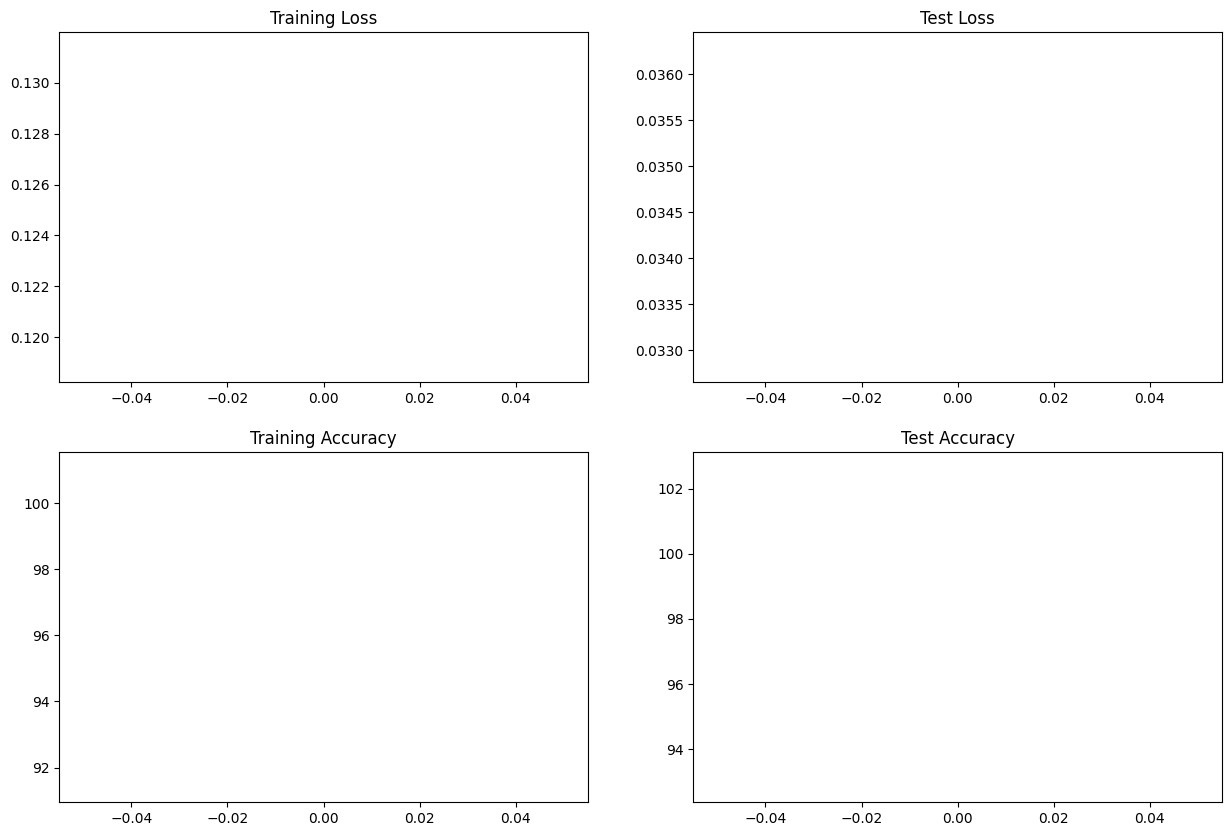

In [28]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")